# Context

In [212]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

При чтении данных из файла используем колонку PassengerId в качестве индекса,
поскольку это уникальные значения, не являющиеся признаками

In [213]:
train = pd.read_csv('./train.csv', index_col='PassengerId')

Размеры изучаемого массива данных: 100 тыс. записей и 12 признаков.

In [214]:
train.shape

(100000, 11)

In [215]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


Расшифровка признаков:
1. PassengerId - идентификатор пассажира;
2. Pclass - класс билета (1 - высокий, 2 - средний, 3 - низкий);
3. Sex - пол;
4. Age - возраст;
5. SibSp - количество членов семьи: братья, сестры (включая сводные), жена, муж;
6. Parch - количество членов семьи: дочь, сын (включая приемные), мать, отец;
7. Ticket - номер билета;
8. Fare - стоимость оплаты;
9. Cabin - номер каюты;
10. Embarked - порт посадки.

Количество выживших пассажиров - 42774 (42%).

In [216]:
len(train[train.Survived == 1])

42774

# Data quality assessment

In [217]:
train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,100000.000000,100000.000000,96708.000000,100000.000000,100000.000000,99866.00000
mean,0.427740,2.106910,38.355472,0.397690,0.454560,43.92933
std,0.494753,0.837727,18.313556,0.862566,0.950076,69.58882
min,0.000000,1.000000,0.080000,0.000000,0.000000,0.68000
25%,0.000000,1.000000,25.000000,0.000000,0.000000,10.04000
50%,0.000000,2.000000,39.000000,0.000000,0.000000,24.46000
75%,1.000000,3.000000,53.000000,1.000000,1.000000,33.50000
max,1.000000,3.000000,87.000000,8.000000,9.000000,744.66000


Для удобства параметры признаков занесем в отдельную таблицу.
Добавим туда:
1. тип данных в колонке;
2. количество значений в колонке;
3. количество пропущенных значений;
4. количество уникальных значений.

In [218]:
columns = pd.DataFrame()
columns['type'] = train.dtypes
columns['count'] = train.count()
columns['missing'] = train.isnull().sum()
columns['unique'] = train.nunique()
columns

,type,count,missing,unique
Survived,int64,100000,0,2
Pclass,int64,100000,0,3
Name,object,100000,0,92144
Sex,object,100000,0,2
Age,float64,96708,3292,173
SibSp,int64,100000,0,7
Parch,int64,100000,0,8
Ticket,object,95377,4623,75331
Fare,float64,99866,134,15935
Cabin,object,32134,67866,26992


Видим, что имеются пропущенные значения в некоторых признаках.
Удалим их из признаков Age, Fare и Embarked.
Также удалим признак Ticket, поскольку выживаемость от него никак не зависит.
Признак Cabin пока не трогаем, иначе мы лишимся большей части данных, что повлияет
на распределение и зависимости.

In [219]:
train_drop = train.dropna(subset=['Age', 'Fare', 'Embarked'])
train_drop.drop('Ticket', axis=1, inplace=True)
columns_drop = pd.DataFrame()
columns_drop['type'] = train_drop.dtypes
columns_drop['count'] = train_drop.count()
columns_drop['missing'] = train_drop.isnull().sum()
columns_drop['unique'] = train_drop.nunique()
columns_drop

C:\Temp\ipykernel_18420\2954424597.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_drop.drop('Ticket', axis=1, inplace=True)


,type,count,missing,unique
Survived,int64,96332,0,2
Pclass,int64,96332,0,3
Name,object,96332,0,88951
Sex,object,96332,0,2
Age,float64,96332,0,173
SibSp,int64,96332,0,7
Parch,int64,96332,0,8
Fare,float64,96332,0,15638
Cabin,object,30961,65371,26175
Embarked,object,96332,0,3


Количество и уникальные значения изменились не сильно, следовательно так и оставим.

Попробуем выяснить зависимость от буквы каюты и шансов на выживание.
Из тех данных, что есть, видно, что больше всего шансов выжить у пассажиров, чья
каюта начинается на буквы F или G.

C:\Temp\ipykernel_18420\3695822173.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_drop['cabin_letter'] = train_drop.Cabin.str[0]


<AxesSubplot:xlabel='cabin_letter', ylabel='Survived'>

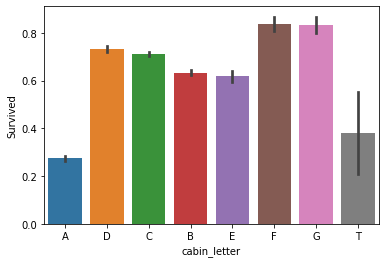

In [220]:
train_drop['cabin_letter'] = train_drop.Cabin.str[0]
sns.barplot(x='cabin_letter', y='Survived', data=train_drop)

Теперь взглянем на количество кают для каждой буквы.

<AxesSubplot:xlabel='cabin_letter', ylabel='count'>

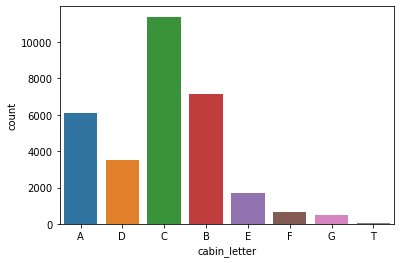

In [221]:
sns.countplot(x='cabin_letter', data=train_drop)

Количество кают, начинающихся на буквы F или G, гораздо меньше других кают, поэтому не стоит принимать номер каюты во внимание.
Удаляем столбец.

In [222]:
train_drop.drop(['Cabin', 'cabin_letter'], axis=1, inplace=True)

C:\Temp\ipykernel_18420\3563676560.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_drop.drop(['Cabin', 'cabin_letter'], axis=1, inplace=True)


In [223]:
train_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96332 entries, 2 to 99999
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  96332 non-null  int64  
 1   Pclass    96332 non-null  int64  
 2   Name      96332 non-null  object 
 3   Sex       96332 non-null  object 
 4   Age       96332 non-null  float64
 5   SibSp     96332 non-null  int64  
 6   Parch     96332 non-null  int64  
 7   Fare      96332 non-null  float64
 8   Embarked  96332 non-null  object 
dtypes: float64(2), int64(4), object(3)
memory usage: 7.3+ MB


Итак, мы избавились от пустых значений, можно проводить обработку далее.

# Data exploration

<b>Анализ Pclass</b>
На графике видно, что количество кают первого и второго класса примерно равно, кают третьего класса на 30% больше.
Но количество спасшихся из кают более высокого класса больше, чем из кают более низкого класса.
Возможно, это связано с физическим местоположением кают третьего класса, вследствие чего из них сложнее было спастись.
Или же пассажиров этого класса просто не пускали на спасательные шлюпки.

<AxesSubplot:xlabel='Pclass', ylabel='count'>

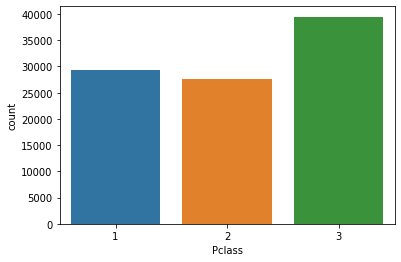

In [224]:
sns.countplot(x='Pclass', data=train_drop)

<AxesSubplot:xlabel='Pclass', ylabel='count'>

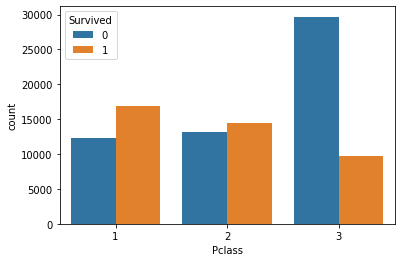

In [225]:
sns.countplot(x='Pclass', data=train_drop, hue='Survived')

<b>Анализ Sex</b>
Хоть количество мужчин на борту было больше, чем количество женщин, последних спаслось в несколько раз больше.
Скорее всего это связано с тем, что сначала на шлюпки сажали женщин, а мужчины просто не успели или не хватило места.

<AxesSubplot:xlabel='Sex', ylabel='count'>

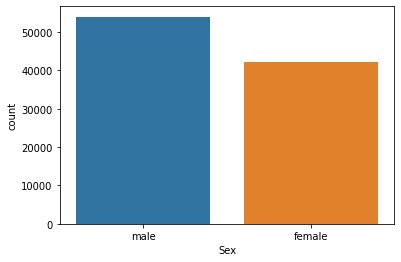

In [226]:
sns.countplot(x='Sex', data=train_drop)

<AxesSubplot:xlabel='Sex', ylabel='count'>

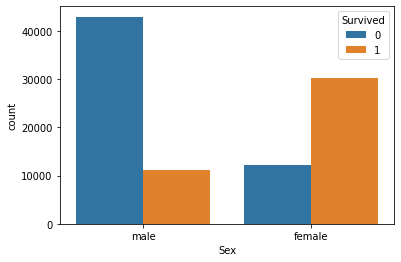

In [227]:
sns.countplot(x='Sex', data=train_drop, hue='Survived')

<b>Анализ Age</b>
На борту в основном были пассажиры молодого возраста 20-30 лет.
Распределение возраста по выжившим полностью повторяет рисунок возраста по пассажирам.
Таким образом, делаем вывод, что какого-либо приоритета по возрасту на спасение не было.
Спасали всех (в первую очередь - женщин).

<AxesSubplot:xlabel='Age', ylabel='count'>

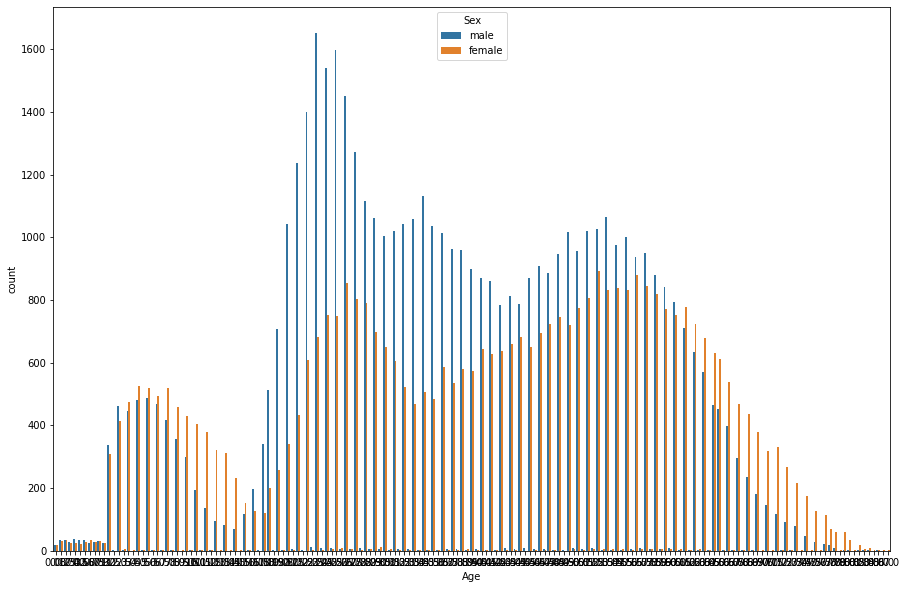

In [228]:
plt.figure(figsize=[15,10])
sns.countplot(x='Age', data=train_drop, hue='Sex')

<AxesSubplot:xlabel='Age', ylabel='count'>

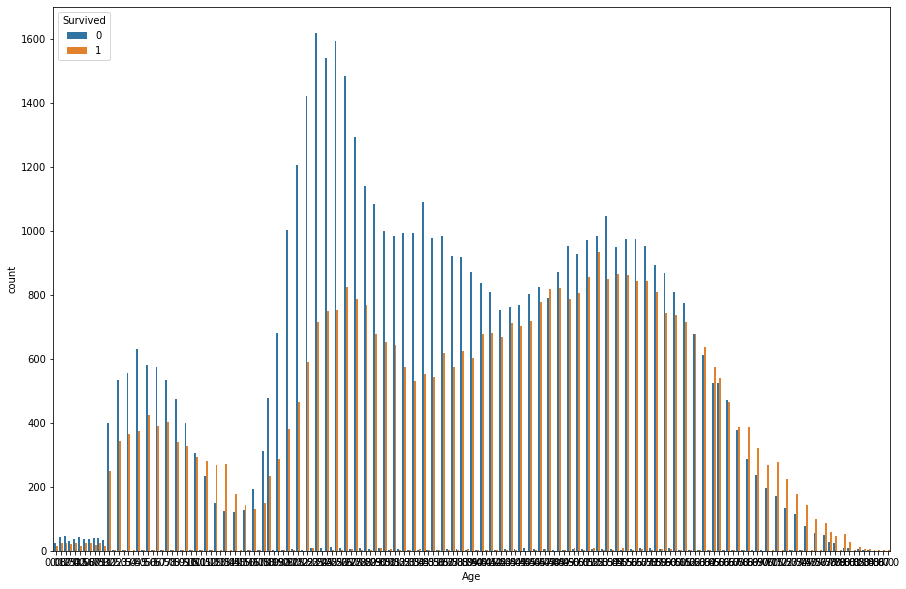

In [229]:
plt.figure(figsize=[15,10])
sns.countplot(x='Age', data=train_drop, hue='Survived')

<b>Анализ SibSp</b>
На борту в основном, были одинокие пассажиры. Совсем немного - с одним членом семьи. И подавляющее меньшинство - большая семья.
Спасались, как видно на графике, без какого-либо приоритета.

<AxesSubplot:xlabel='SibSp', ylabel='count'>

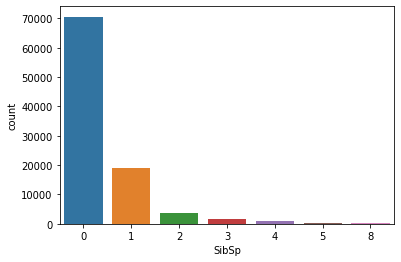

In [230]:
sns.countplot(x='SibSp', data=train_drop)

<AxesSubplot:xlabel='SibSp', ylabel='count'>

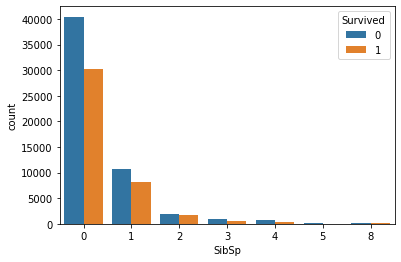

In [231]:
sns.countplot(x='SibSp', data=train_drop, hue="Survived")

<b>Анализ Parch</b>
По аналогии с предыдущим признаком, спасались как могли.

<AxesSubplot:xlabel='Parch', ylabel='count'>

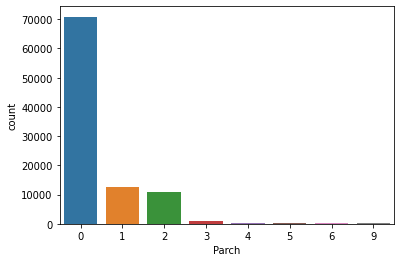

In [232]:
sns.countplot(x='Parch', data=train_drop)

<AxesSubplot:xlabel='Parch', ylabel='count'>

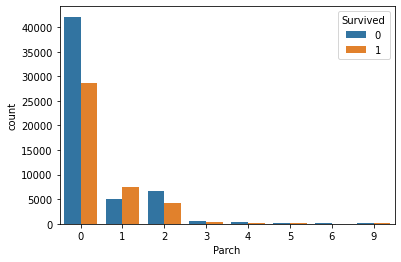

In [233]:
sns.countplot(x='Parch', data=train_drop, hue="Survived")

<b>Анализ Fare</b>
Видно, что максимальное значение сильно удалено от среднего и медианы, следовательно, есть выбросы.
Уберем выбросы, выходящие за 90й квантиль.
Видим, что больше всего билетов было куплено за цену в районе 10 долларов (видимо, 3 класс), в 2 раза меньше - за цену в 30 долларов (2 класс) и за первый класс было продано менее всего билетов со средней ценой в 70 долларов.

In [234]:
q = train_drop.Fare.quantile(0.90)
fare = train_drop[train_drop.Fare < q]

<AxesSubplot:xlabel='Fare', ylabel='Count'>

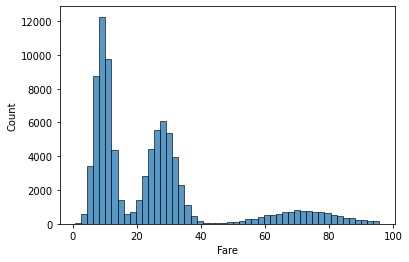

In [235]:
sns.histplot(fare.Fare, bins=50)

<b>Анализ Embarked</b>
Из графиков видно, что подавляющее большинство пассажиров было из Southampton, 20к - из Cherbourg, и остальные - из Queenstown.


<AxesSubplot:xlabel='Embarked', ylabel='count'>

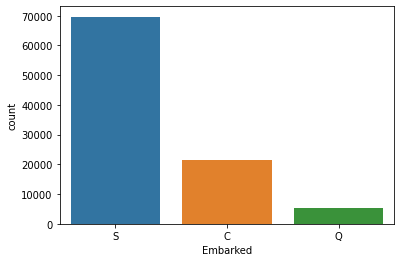

In [236]:
sns.countplot(x='Embarked', data=train_drop)

<AxesSubplot:xlabel='Embarked', ylabel='count'>

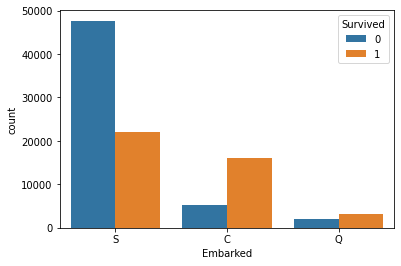

In [237]:
sns.countplot(x='Embarked', data=train_drop, hue='Survived')

Интересно, что очень много пассажиров из Cherbourg спаслось, погибло лишь немного.
Возможно, что почти все они - богатые женщины (из кают бизнес-классов)?
2 графика ниже это подтверждают.

<AxesSubplot:xlabel='Embarked', ylabel='count'>

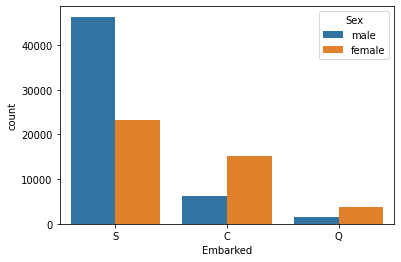

In [238]:
sns.countplot(x='Embarked', data=train_drop, hue='Sex')

<AxesSubplot:xlabel='Embarked', ylabel='count'>

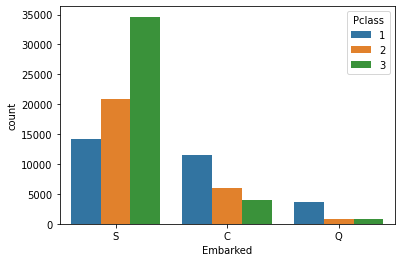

In [239]:
sns.countplot(x='Embarked', data=train_drop, hue='Pclass')

# Summary

Вывод: больше всего шансов спастись у богатых женщин из кают бизнес-класса.
